# hk total MSW generated per capita & hk total disposal per capita & hk total recycling volume per capita & hk total recycling rate

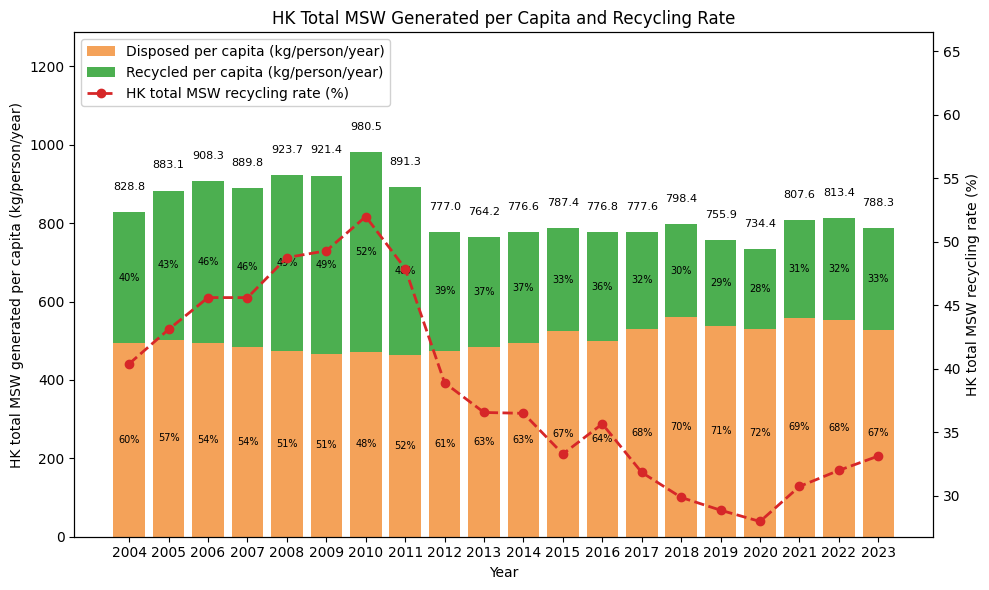

In [22]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys

def _ensure(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("numpy")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path

# ---------- load data (main HK MSW sheet) ----------
data_path = Path("../General Stats_G@C_clean.xlsx")
sheet_name_msw = "HK MSW Volume and Recycling Rat"

df_msw = pd.read_excel(data_path, sheet_name=sheet_name_msw, engine="openpyxl")

# Helper to clean numeric columns with commas
def to_number(series):
    return pd.to_numeric(series.astype(str).str.replace(",", ""), errors="coerce")

# =========================================================
# HK total MSW generated per capita:
# stacked bar (disposed per capita & recycled per capita) + recycling rate line
# =========================================================

col_year = "Year"
col_gen  = "HK total MSW generated (tonnes)"
col_disp = "HK total MSW disposed (tonnes)"
col_rec  = "HK total MSW recycled (tonnes)"
col_pop  = "HK total population (mid-year)"
col_rate = "HK total MSW recycling rate"

mask_hk = (
    df_msw[col_year].notna()
    & df_msw[col_gen].notna()
    & df_msw[col_disp].notna()
    & df_msw[col_rec].notna()
    & df_msw[col_pop].notna()
    & df_msw[col_rate].notna()
)

sub_hk = df_msw.loc[
    mask_hk, [col_year, col_gen, col_disp, col_rec, col_pop, col_rate]
].copy()

# Clean numeric columns
sub_hk[col_gen]  = to_number(sub_hk[col_gen])
sub_hk[col_disp] = to_number(sub_hk[col_disp])
sub_hk[col_rec]  = to_number(sub_hk[col_rec])
sub_hk[col_pop]  = to_number(sub_hk[col_pop])

# Per-capita (kg/person/year)
sub_hk["disp_pc_kg"] = sub_hk[col_disp] * 1000.0 / sub_hk[col_pop]
sub_hk["rec_pc_kg"]  = sub_hk[col_rec]  * 1000.0 / sub_hk[col_pop]
sub_hk["total_pc_kg"] = sub_hk["disp_pc_kg"] + sub_hk["rec_pc_kg"]

# ---- Recycling rate as numeric % ----
rate_raw = sub_hk[col_rate]
rate_series = pd.to_numeric(
    rate_raw.astype(str).str.rstrip("%"),  # remove "%"
    errors="coerce"
)

if rate_series.max() <= 1.0:
    sub_hk["recycling_rate_pct"] = rate_series * 100.0
else:
    sub_hk["recycling_rate_pct"] = rate_series

# ---------- X axis ----------
x_hk = np.arange(len(sub_hk))
x_labels_hk = sub_hk[col_year].astype(int).astype(str).tolist()

# ---------- plot ----------
fig2, ax1_hk = plt.subplots(figsize=(10, 6))

# Stacked bars: disposed + recycled per capita
bars_disp = ax1_hk.bar(
    x_hk,
    sub_hk["disp_pc_kg"],
    color="#f4a259",
    label="Disposed per capita (kg/person/year)",
)
bars_rec = ax1_hk.bar(
    x_hk,
    sub_hk["rec_pc_kg"],
    bottom=sub_hk["disp_pc_kg"],
    color="#4caf50",
    label="Recycled per capita (kg/person/year)",
)

ax1_hk.set_xlabel("Year")
ax1_hk.set_ylabel("HK total MSW generated per capita (kg/person/year)", color="black")
ax1_hk.tick_params(axis="y", labelcolor="black")
ax1_hk.set_xticks(x_hk)
ax1_hk.set_xticklabels(x_labels_hk, rotation=0)

# Headroom for bar labels
y1_min_hk, y1_max_hk = ax1_hk.get_ylim()
ax1_hk.set_ylim(y1_min_hk, y1_max_hk * 1.25)
y1_range_hk = ax1_hk.get_ylim()[1] - ax1_hk.get_ylim()[0]
offset_bar_hk = y1_range_hk * 0.04

# Label each stack with TOTAL per-capita generated
for xi, total_pc in zip(x_hk, sub_hk["total_pc_kg"]):
    ax1_hk.text(
        xi,
        total_pc + offset_bar_hk,
        f"{total_pc:.1f}",
        ha="center",
        va="bottom",
        fontsize=8,
        color="black",
    )

# Inside stack: show orange/green percentage of total
for xi, disp_pc, rec_pc, total_pc in zip(
    x_hk,
    sub_hk["disp_pc_kg"],
    sub_hk["rec_pc_kg"],
    sub_hk["total_pc_kg"],
):
    if total_pc > 0:
        disp_pct = disp_pc / total_pc * 100
        rec_pct  = rec_pc  / total_pc * 100
    else:
        disp_pct = rec_pct = 0.0

    ax1_hk.text(
        xi,
        disp_pc / 2.0,
        f"{disp_pct:.0f}%",
        ha="center",
        va="center",
        fontsize=7,
        color="black",
    )

    ax1_hk.text(
        xi,
        disp_pc + rec_pc / 2.0,
        f"{rec_pct:.0f}%",
        ha="center",
        va="center",
        fontsize=7,
        color="black",
    )

# Line: HK total MSW recycling rate (%)
ax2_hk = ax1_hk.twinx()
line_rate, = ax2_hk.plot(
    x_hk,
    sub_hk["recycling_rate_pct"],
    color="tab:red",
    linestyle="--",
    marker="o",
    linewidth=2,
    alpha=1,                      # <- makes the whole line + markers 60% opaque
    label="HK total MSW recycling rate",
)

ax2_hk.set_ylabel("HK total MSW recycling rate (%)", color="black")
ax2_hk.tick_params(axis="y", labelcolor="black")
ax2_hk.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Headroom for line labels
y2_min_hk, y2_max_hk = ax2_hk.get_ylim()
ax2_hk.set_ylim(y2_min_hk, y2_max_hk * 1.25)
y2_range_hk = ax2_hk.get_ylim()[1] - ax2_hk.get_ylim()[0]

# *** More space between red point and red text ***


# Legend and title
lines_hk = [bars_disp, bars_rec, line_rate]
labels_hk = [
    "Disposed per capita (kg/person/year)",
    "Recycled per capita (kg/person/year)",
    "HK total MSW recycling rate (%)",
]
ax1_hk.legend(lines_hk, labels_hk, loc="upper left", frameon=True, framealpha=0.9)

plt.title(
    "HK Total MSW Generated per Capita and Recycling Rate"
)

fig2.tight_layout()
plt.show()


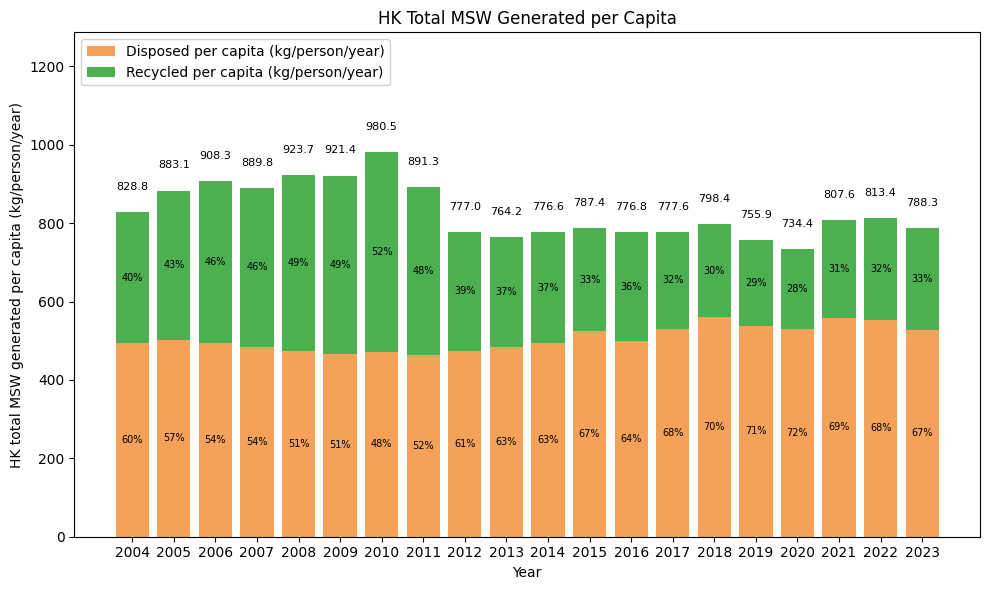

In [1]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys

def _ensure(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("numpy")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- load data (main HK MSW sheet) ----------
data_path = Path("../General Stats_G@C_clean.xlsx")
sheet_name_msw = "HK MSW Volume and Recycling Rat"

df_msw = pd.read_excel(data_path, sheet_name=sheet_name_msw, engine="openpyxl")

# Helper to clean numeric columns with commas
def to_number(series):
    return pd.to_numeric(series.astype(str).str.replace(",", ""), errors="coerce")

# =========================================================
# HK total MSW generated per capita:
# stacked bar (disposed per capita & recycled per capita)
# =========================================================

col_year = "Year"
col_gen  = "HK total MSW generated (tonnes)"
col_disp = "HK total MSW disposed (tonnes)"
col_rec  = "HK total MSW recycled (tonnes)"
col_pop  = "HK total population (mid-year)"
col_rate = "HK total MSW recycling rate"

mask_hk = (
    df_msw[col_year].notna()
    & df_msw[col_gen].notna()
    & df_msw[col_disp].notna()
    & df_msw[col_rec].notna()
    & df_msw[col_pop].notna()
    & df_msw[col_rate].notna()
)

sub_hk = df_msw.loc[
    mask_hk, [col_year, col_gen, col_disp, col_rec, col_pop, col_rate]
].copy()

# Clean numeric columns
sub_hk[col_gen]  = to_number(sub_hk[col_gen])
sub_hk[col_disp] = to_number(sub_hk[col_disp])
sub_hk[col_rec]  = to_number(sub_hk[col_rec])
sub_hk[col_pop]  = to_number(sub_hk[col_pop])

# Per-capita (kg/person/year)
sub_hk["disp_pc_kg"] = sub_hk[col_disp] * 1000.0 / sub_hk[col_pop]
sub_hk["rec_pc_kg"]  = sub_hk[col_rec]  * 1000.0 / sub_hk[col_pop]
sub_hk["total_pc_kg"] = sub_hk["disp_pc_kg"] + sub_hk["rec_pc_kg"]

# Recycling rate as numeric % (still computed if you need it later)
rate_raw = sub_hk[col_rate]
rate_series = pd.to_numeric(
    rate_raw.astype(str).str.rstrip("%"),  # remove "%"
    errors="coerce"
)
if rate_series.max() <= 1.0:
    sub_hk["recycling_rate_pct"] = rate_series * 100.0
else:
    sub_hk["recycling_rate_pct"] = rate_series

# ---------- X axis ----------
x_hk = np.arange(len(sub_hk))
x_labels_hk = sub_hk[col_year].astype(int).astype(str).tolist()

# ---------- plot ----------
fig2, ax1_hk = plt.subplots(figsize=(10, 6))

# Stacked bars: disposed + recycled per capita
bars_disp = ax1_hk.bar(
    x_hk,
    sub_hk["disp_pc_kg"],
    color="#f4a259",
    label="Disposed per capita (kg/person/year)",
)
bars_rec = ax1_hk.bar(
    x_hk,
    sub_hk["rec_pc_kg"],
    bottom=sub_hk["disp_pc_kg"],
    color="#4caf50",
    label="Recycled per capita (kg/person/year)",
)

ax1_hk.set_xlabel("Year")
ax1_hk.set_ylabel("HK total MSW generated per capita (kg/person/year)", color="black")
ax1_hk.tick_params(axis="y", labelcolor="black")
ax1_hk.set_xticks(x_hk)
ax1_hk.set_xticklabels(x_labels_hk, rotation=0)

# Headroom for bar labels
y1_min_hk, y1_max_hk = ax1_hk.get_ylim()
ax1_hk.set_ylim(y1_min_hk, y1_max_hk * 1.25)
y1_range_hk = ax1_hk.get_ylim()[1] - ax1_hk.get_ylim()[0]
offset_bar_hk = y1_range_hk * 0.04

# Label each stack with TOTAL per-capita generated
for xi, total_pc in zip(x_hk, sub_hk["total_pc_kg"]):
    ax1_hk.text(
        xi,
        total_pc + offset_bar_hk,
        f"{total_pc:.1f}",
        ha="center",
        va="bottom",
        fontsize=8,
        color="black",
    )

# Inside stack: show orange/green percentage of total
for xi, disp_pc, rec_pc, total_pc in zip(
    x_hk,
    sub_hk["disp_pc_kg"],
    sub_hk["rec_pc_kg"],
    sub_hk["total_pc_kg"],
):
    if total_pc > 0:
        disp_pct = disp_pc / total_pc * 100
        rec_pct  = rec_pc  / total_pc * 100
    else:
        disp_pct = rec_pct = 0.0

    ax1_hk.text(
        xi,
        disp_pc / 2.0,
        f"{disp_pct:.0f}%",
        ha="center",
        va="center",
        fontsize=7,
        color="black",
    )

    ax1_hk.text(
        xi,
        disp_pc + rec_pc / 2.0,
        f"{rec_pct:.0f}%",
        ha="center",
        va="center",
        fontsize=7,
        color="black",
    )

# Legend and title (bars only)
lines_hk = [bars_disp, bars_rec]
labels_hk = [
    "Disposed per capita (kg/person/year)",
    "Recycled per capita (kg/person/year)",
]
ax1_hk.legend(lines_hk, labels_hk, loc="upper left", frameon=True, framealpha=0.9)

plt.title("HK Total MSW Generated per Capita")

fig2.tight_layout()
plt.show()
